#**NLP: Multi-Tag Predictions of Cross Validated Stack Exchange Questions**


> Name: Tsang Fan Yam (Kelvin)  
URN: 6656440  
Group: 2

> Dataset Overview: 
The “Questions from Cross Validated Stack Exchange” is a dataset containing text of questions and answers from Cross Validated website from the Stack Exchange network. The dataset comprises of over 85,000 questions and 1315 unique tags. The dataset provides enough text information to classify and model appropriate tags for a given question.

> Project Scope: Only top 20 labels are chosen. Therefore, around 29000 data are removed as they don't carry any label. Around 56000 data are used in this project.









###**0. Google Colab Environment Setup & Importing Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os

os.chdir("./drive/MyDrive/Colab_Notebooks/NLP_project/")
print(os.listdir("input_data/"))

Mounted at /content/drive
['final_50.csv', 'final_10.csv', 'final_20.csv', 'final_10_cleaned.csv', 'elmo_data.csv', 'elmo_data.npy', 'labels.npy', 'original', 'final_20_cleaned.csv']


In [ ]:
!pip install -q tensorflow-text
!pip install tensorflow-addons
!pip install -q -U keras-tuner
!pip install --upgrade gensim # Gensim is upgraded to help loading Fasttext subword embeddings
!pip install scikit-multilearn
!pip install wordcloud

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import random as rn
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import spacy
import re
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import fasttext
from gensim.test.utils import datapath
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import kerastuner as kt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


###**1. Preprocessing Dataset**
> In this section, there are 3 goals: 
* Removing non-input text & non-label columns (e.g. OwnerUserID, CreationDate)
* Selecting top 20 labels, and removing the other 1295 label columns
* Removing data without any labels


In [ ]:
# Showing features in data Questions.csv
df_questions = pd.read_csv('input_data/original/Questions.csv', encoding='iso-8859-1')
df_tags = pd.read_csv('input_data/original/Tags.csv', encoding='iso-8859-1')
df_questions

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=..."
1,21,59.0,2010-07-19T19:24:36Z,4,Forecasting demographic census,<p>What are some of the ways to forecast demog...
2,22,66.0,2010-07-19T19:25:39Z,208,Bayesian and frequentist reasoning in plain En...,<p>How would you describe in plain English the...
3,31,13.0,2010-07-19T19:28:44Z,138,What is the meaning of p values and t values i...,<p>After taking a statistics course and then t...
4,36,8.0,2010-07-19T19:31:47Z,58,Examples for teaching: Correlation does not me...,"<p>There is an old saying: ""Correlation does n..."
...,...,...,...,...,...,...
85080,179305,93533.0,2015-10-29T22:09:54Z,0,Interpretation of global test (p-value) of the...,<p>My data:<br>\nI have a dichotomous outcome:...
85081,179313,93436.0,2015-10-29T23:06:26Z,0,Testing my linear model,<p>I have used R to fit a linear model to some...
85082,179315,41749.0,2015-10-29T23:13:41Z,1,How do I know a simple validation result is st...,"<p>In computer science literature, we always s..."
85083,179319,90490.0,2015-10-29T23:40:52Z,1,Kendall conditional independence test statistic,<p>Given the two continuous random variables $...


In [ ]:
# Number of tags in the dataset
grouped_tags = df_tags.groupby("Tag", sort='count').size().reset_index(name='count')
grouped_tags.Tag.describe()

count               1315
unique              1315
top       network-layout
freq                   1
Name: Tag, dtype: object

In [ ]:
# Selecting the top 20 labels out of 1315 labels
num_classes = 20
grouped_tags = df_tags.groupby("Tag").size().reset_index(name='count')
most_common_tags = grouped_tags.nlargest(num_classes, columns="count")
df_tags.Tag = df_tags.Tag.apply(lambda tag : tag if tag in most_common_tags.Tag.values else None)
df_tags = df_tags.dropna()

# Combining the Title and Body into a single column called Text
def strip_html_tags(body):
    regex = re.compile('<.*?>')
    return re.sub(regex, '', body)

df_questions['Body'] = df_questions['Body'].apply(strip_html_tags)
df_questions['Text'] = df_questions['Title'] + ' ' + df_questions['Body']

# Denormalize tables
def tags_for_question(question_id):
    return df_tags[df_tags['Id'] == question_id].Tag.values

def add_tags_column(row):
    row['Tags'] = tags_for_question(row['Id'])
    return row

df_questions = df_questions.apply(add_tags_column, axis=1)
pd.set_option('display.max_colwidth', 80)
df_questions[['Id', 'Text', 'Tags']].head()

,Id,Text,Tags
0,6,"The Two Cultures: statistics vs. machine learning? Last year, I read a blog ...",[machine-learning]
1,21,Forecasting demographic census What are some of the ways to forecast demogra...,[]
2,22,Bayesian and frequentist reasoning in plain English How would you describe i...,[bayesian]
3,31,What is the meaning of p values and t values in statistical tests? After tak...,[hypothesis-testing]
4,36,Examples for teaching: Correlation does not mean causation There is an old s...,[correlation]


In [19]:
# Turning the labels into one-hot encoding form
mlb = MultiLabelBinarizer()
df_labels = pd.DataFrame(mlb.fit_transform(df_questions.Tags.values),columns=mlb.classes_)

# Combining 
df_combined = pd.concat([df_questions, df_labels], axis=1)

# Dropping the redundant columns
df_combined = df_combined.drop(columns = ['Id', 'OwnerUserId', 'CreationDate', 'Score', 'Title', 'Body', 'Tags'], axis=1)

# Dropping the rows without any label
df_final = df_combined[df_combined[df_combined.columns[1:]].sum(axis=1) != 0]

# Reset the index in pandas dataframe
df_final = df_final.reset_index(drop=True)

# Two csv files have been combined into a single Pandas dataframe in shape 56405 x 21, where the first column is text and the other 20 columns are labels
df_final.head()

,Text,anova,bayesian,classification,clustering,correlation,distributions,hypothesis-testing,logistic,machine-learning,mathematical-statistics,mixed-model,multiple-regression,neural-networks,normal-distribution,probability,r,regression,self-study,statistical-significance,time-series
0,The Two Cultures: statistics vs. machine learn...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Bayesian and frequentist reasoning in plain En...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,What is the meaning of p values and t values i...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Examples for teaching: Correlation does not me...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,How Large a Difference Can Be Expected Between...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Data is saved to a csv file to avoid processing the dataset again
df_final.to_csv('input_data/final_20.csv', index=False)
X = df_final.iloc[:, 0]
y = df_final.iloc[:, 1:]

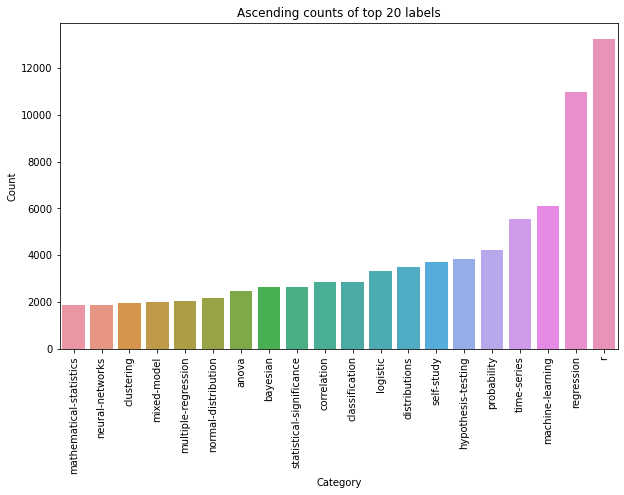

In [17]:
# Chart1: Counting the abundnace of each labels and put them into a pandas dataframe
counts = []
categories = list(y.columns.values)
for i in categories:
    counts.append(y[i].sum())

count_dict = {categories[i]: counts[i] for i in range(len(categories))}
count_df = pd.DataFrame(list(count_dict.items()))
count_df.columns =["Category","Count"]

# Put the labels in ascending 
ordered_count_df = count_df.groupby(["Category"])['Count'].aggregate(np.median).reset_index().sort_values('Count')
plt.figure(figsize=(10,6))
sns.barplot(ordered_count_df["Category"], ordered_count_df["Count"])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Ascending counts of top 20 labels")
plt.xticks(rotation=90)
plt.show()

**Chart1**
> Chart1: It could be observed that the dataset is imbalanced. There are significantly more data in label "regression" and label "R". Imbalance data might lead to bias prediction towards dominant labels, as weights in the neural networks are updated more frequently by the dominant labels. Class weight should be applied when training the model in later stage.



###**2. Text Preprocessing**

> Techniques applied:
* Stopwords are removed
* Punctuations are removed
* Lemmitization is applied
* Meaningless single characters are removed (e.g. n, e, u). However, meaningful single characters are excluded, including "r", "p", and "t", as they are responsible for statistical word such as "p-value", "t-statistics", and "R programming language"
* Double spacing is converted into single spacing

> Techniques NOT applied:
* Tokenisation is not needed to turn the words into word embedding in the next stage
* N-grams, it is experimented by other groupmates






In [7]:
# Loading the processed dataset from last section
df_final = pd.read_csv('input_data/final_20.csv', encoding='iso-8859-1')
X = df_final.iloc[:, 0]
y = df_final.iloc[:, 1:]

In [217]:
# Use of Spacy
nlp = spacy.load("en_core_web_sm")

In [218]:
def clean_text(docs, logging=True):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 10000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [token for token in doc if not token.is_stop and not token.is_punct]
        tokens = [token.lemma_.lower().strip() for token in tokens if token.lemma_ != '-PRON-']
        tokens = ' '.join(tokens)
        tokens = re.sub('\d', ' ', tokens)
        tokens = re.sub(r'\b[^rpt]\b', ' ', tokens)
        tokens = re.sub(r'[^\w\s]', ' ', tokens)
        tokens = re.sub(' +', ' ', tokens)
        texts.append(tokens)
    return pd.Series(texts)

X_array = clean_text(np.array(X))

Processed 10000 out of 56405 documents.
Processed 20000 out of 56405 documents.
Processed 30000 out of 56405 documents.
Processed 40000 out of 56405 documents.
Processed 50000 out of 56405 documents.


**Comparison of original text and cleaned text:**




In [219]:
# Original text:
X.iloc[20]

"Using ANN in time series with limited observations I'm trying to predict weekly market shares over time with a small data set (190 examples and 4 inputs). \n\nMy questions are the following:\n\n\nIs there a particular technique for small number of observations? (i.e., I heard that you could train a network with white noise to avoid the cross-validation.) \nDo I have to filter data when i'm working with time series? (i.e., account for seasonal dummies) \n\n"

In [220]:
# Cleaned text:
X_array[20]

'ann time series limited observation try predict weekly market share time small data set example input question follow particular technique small number observation hear train network white noise avoid cross validation filter datum work time series account seasonal dummy '

In [ ]:
# Cleaned data is combined with labels and saved as csv file
df_X = pd.DataFrame(X_array, columns=['text'])
df_cleaned = pd.concat([df_X, y], axis=1)

In [ ]:
pd.DataFrame(df_cleaned).to_csv("input_data/final_20_cleaned.csv", index=False)

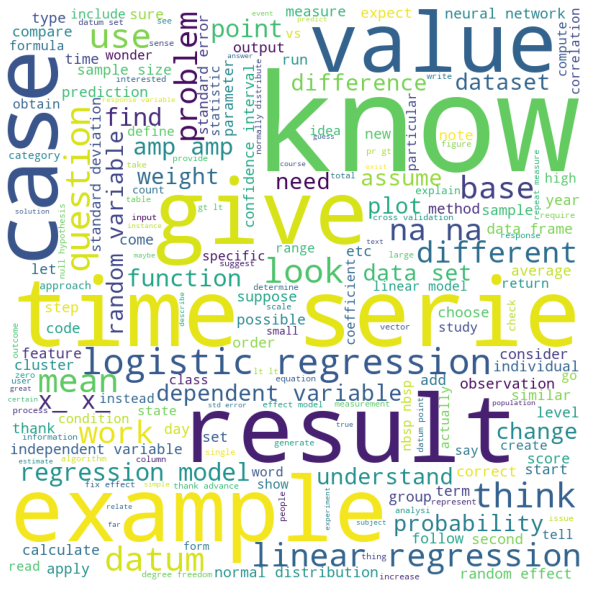

In [250]:
# Chart2: Word Cloud of all words in the cleaned text
comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in X_array:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

**Chart 2**

> Source: https://www.geeksforgeeks.org/generating-word-cloud-python/#:~:text=Word%20Cloud%20is%20a%20data,data%20from%20social%20network%20websites.


> Chart 2: Word cloud is one of the techniques in NLP to represent text. The size of each word indicates its importance and frequency. Some of the labels' names can be observed in the word cloud, e.g. regression and time-series.



###**3. Train-test Split, Text Encoding & Loading Pre-trained Word Embeddings**

> This section summarises the extra works to be done before training the model.





In [20]:
# Loading the data saved in last section
df_final_cleaned = pd.read_csv('input_data/final_20_cleaned.csv', encoding='iso-8859-1')

# Splitting into text(X) and labels(y)
X_cleaned = df_final_cleaned.iloc[:, 0]
y_cleaned = df_final_cleaned.iloc[:, 1:]

####**3.1. Stratified train-test split**

> From the table below, (15, 19) means that the data carry label 15 and label 19. (19, 19) means that the data carry only label 19.


> Splitting ratio: 80-20 splitting ratio is chosen as there are only 56000 data in total. Around 11000 data are reserved for testing. After considering there are 20 labels with over 200 combinations of differnt labels, there shouldn't be too few testing data. From the table below, there are only 1 or 2 testing data for some combinations of labels (e.g. (8,10), (7,13)).



> Stratified sampling: It is used to make sure both dataset have the same ratio of combination of label. It could be observed that all combinations of label are having the same ratio of 8:2 in the table.


> Also, all members in the group has agreed on using the same library(scikit-multilearn) and same random seed(3) to split the data in order to obtain the same training and testing data. It would be more convenient for us to compare our models in the next stage.




In [6]:
X_list = np.array([[x] for x in np.array(X_cleaned)])
np.random.seed(3)
X_train, y_train, X_test, y_test = iterative_train_test_split(X_list, np.array(y_cleaned), test_size = 0.2)
X_train = np.array([x[0] for x in X_train])
X_test = np.array([x[0] for x in X_test])
pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y_train), order=2) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y_test), order=2) for combination in row)
}).T.fillna(0.0)

,"(1, 1)","(4, 4)","(8, 8)","(2, 2)","(19, 19)","(15, 19)","(15, 15)","(0, 0)","(3, 3)","(16, 16)","(5, 5)","(5, 16)","(3, 15)","(17, 17)","(6, 6)","(12, 12)","(12, 19)","(5, 13)","(13, 13)","(5, 9)","(6, 9)","(9, 14)","(5, 6)","(9, 9)","(5, 14)","(14, 14)","(6, 14)","(9, 17)","(1, 5)","(4, 17)","(4, 9)","(4, 16)","(9, 16)","(10, 10)","(17, 19)","(15, 17)","(10, 15)","(0, 15)","(0, 16)","(15, 16)",...,"(10, 11)","(0, 11)","(10, 19)","(2, 18)","(4, 10)","(0, 4)","(5, 11)","(8, 13)","(0, 19)","(8, 10)","(7, 13)","(1, 3)","(7, 9)","(3, 10)","(0, 7)","(1, 11)","(4, 5)","(10, 13)","(5, 7)","(9, 11)","(0, 5)","(4, 12)","(2, 9)","(12, 18)","(0, 14)","(11, 14)","(11, 13)","(1, 18)","(9, 10)","(3, 6)","(0, 3)","(0, 2)","(12, 14)","(6, 12)","(3, 9)","(1, 12)","(5, 10)","(3, 7)","(2, 10)","(12, 13)"
train,2125.0,2297.0,4871.0,2305.0,4447.0,978.0,10589.0,2004.0,1562.0,8767.0,2801.0,65.0,260.0,2986.0,3095.0,1518.0,69.0,266.0,1745.0,132.0,89.0,221.0,133.0,1510.0,517.0,3374.0,67.0,189.0,93.0,57.0,49.0,330.0,115.0,1598.0,117.0,129.0,624.0,429.0,198.0,1602.0,...,22.0,46.0,32.0,41.0,16.0,33.0,10.0,34.0,42.0,5.0,8.0,15.0,8.0,7.0,15.0,15.0,42.0,10.0,15.0,22.0,11.0,7.0,8.0,2.0,4.0,6.0,9.0,18.0,10.0,15.0,4.0,5.0,10.0,2.0,8.0,10.0,5.0,8.0,4.0,3.0
test,531.0,574.0,1218.0,576.0,1112.0,244.0,2647.0,501.0,390.0,2192.0,700.0,16.0,65.0,746.0,774.0,379.0,17.0,66.0,436.0,33.0,22.0,55.0,33.0,378.0,129.0,843.0,17.0,47.0,23.0,14.0,12.0,83.0,29.0,400.0,29.0,32.0,156.0,107.0,49.0,401.0,...,6.0,11.0,8.0,10.0,4.0,8.0,2.0,9.0,11.0,1.0,2.0,4.0,2.0,2.0,4.0,4.0,11.0,2.0,4.0,5.0,3.0,2.0,3.0,1.0,1.0,2.0,2.0,4.0,2.0,4.0,1.0,1.0,2.0,0.0,2.0,2.0,1.0,2.0,1.0,1.0


####**3.2. Encoding the text in X_train & X_test**

#####**3.2.1. Text encoding**

> Texts are first encoded into one-dimension numbers. It will be more convenient for mapping words from the word embedding models.



In [21]:
train_text = X_train.tolist()
token = keras.preprocessing.text.Tokenizer()
token.fit_on_texts(train_text)

In [22]:
vocab_size  = len(token.word_index) + 1
print('Total number of vocabs:', vocab_size)

Total number of vocabs: 58723


In [23]:
# Encode X_train
encoded_text = token.texts_to_sequences(train_text)

# Encode X_test
test_text = X_test.tolist()
encoded_test_text = token.texts_to_sequences(test_text)

#####**3.2.2. Choosing the right sentence length**

> All input texts have to be converted into same length to put into the neural network. From the histogram, it is observed that most of the data is of the sentence length of 0~200. To minimize the loss of information, maximum length of 300 is chosen.





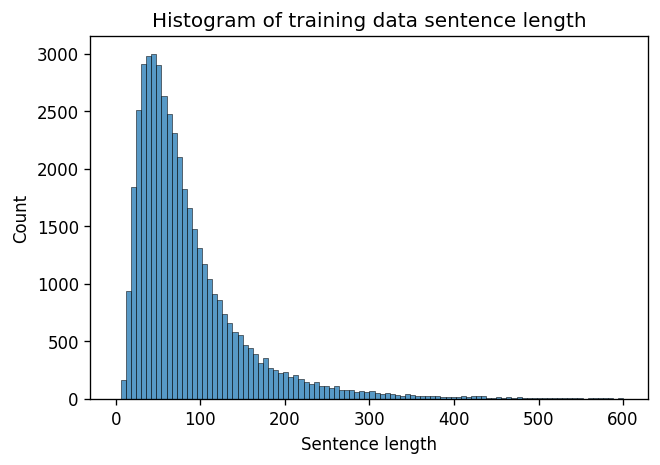

In [24]:
length = [len(item) for item in encoded_text]
plt.figure(figsize=(6, 4), dpi=120)
sns.histplot(data=length, bins=100, binrange=(0,600))
plt.xlabel('Sentence length')
plt.title('Histogram of training data sentence length')
plt.show()

In [25]:
# Padding X_train
max_length = 300
X_train_pad = keras.preprocessing.sequence.pad_sequences(encoded_text, maxlen=max_length, padding='post')
X_train_pad.shape

(45190, 300)

In [26]:
# Padding X_test
X_test_pad = keras.preprocessing.sequence.pad_sequences(encoded_test_text, maxlen=max_length, padding='post')
X_test_pad.shape

(11215, 300)


> For the training data, there are 45190 rows with sentence length of 300. For the testing data, there are 11215 rows with sentence length of 300.



####**3.3. Importing pre-trained word embeddings (Glove & Fasttext)**

> Glove-100D, Glove-300D, Fasttext, Fasttext with subwords, and ELMO are all potential candidates in the experimental setup. However, due to Out of Memory(OOM) problem, it is no possible in this stage to use ELMO to turn each word into 1024-dimensions vector. 

> The other four pre-trained embeddings are tried with baseline model. To avoid testing too many potential combinations of network structure in the latter stage, only two are chosen. It is observed that Glove-300D and Fasttext with subword are the two embeddings with better performances.






#####**3.3.1. Glove - 300D**

> Reference: https://nlp.stanford.edu/projects/glove/

> Missing vocabruaries(vocabs): Out of 58723 vocabs, 22205 vocabs are not found in Glove. It is observed that most of the missing vocabs are undefined words and mispelled words. The first 10 missing vocabs are printed below.






In [ ]:
# Loading the Stanford GloVe model
glove2word2vec(glove_input_file='word_embeddings/glove.42B.300d.txt', word2vec_output_file="word_embeddings/gensim_glove_vectors.txt")
glove_model = KeyedVectors.load_word2vec_format("word_embeddings/gensim_glove_vectors.txt", binary=False)

In [24]:
# Creating word embedding matrix from Glove model
glove_300d_matrix = np.zeros((vocab_size, 300))
missing_vocabs = []
for word, index in token.word_index.items():
    try:
        vector = glove_model[word]
        glove_300d_matrix[index] = vector
    except:
        missing_vocabs.append(word)

In [66]:
print('Number of missing vocabs:', len(missing_vocabs))
print('Missing vocabs in the data:', missing_vocabs[:10])

Number of missing vocabs: 22205
Missing vocabs in the data: ['ã¢â²', 'iã£', 'glmnet', 'glmer', 'dnorm', 'nanã£', 'loglik', 'bootstrappe', 'randomforest', 'xreg']


In [26]:
# Save the matrix as loading the Glove model taking a considerable amount of time
np.save('word_embeddings/glove_matrix.npy', glove_300d_matrix)

In [14]:
# Load the matrix locally
glove_300d_matrix = np.load('word_embeddings/glove_matrix.npy')

#####**3.3.2. Fasttext Subword - 300D**

> Reference: https://fasttext.cc/





In [25]:
# Loading binary version of Fasttext
fasttext_sub_vectors = fasttext.load_facebook_vectors('./word_embeddings/fasttext-300d-2M-subword/fasttext.bin')

In [26]:
# Creating vector matrix for embedding layer
fasttext_sub_matrix = np.zeros((vocab_size, 300))
missing_vocabs = []
for word, index in token.word_index.items():
    try:
        vector = fasttext_sub_vectors[word]
        fasttext_sub_matrix[index] = vector
    except:
        missing_vocabs.append(word)

In [28]:
# Save the matrix as loading the Fasttext vectors taking a considerable amount of time
np.save('word_embeddings/fasttext_matrix_sub.npy', fasttext_sub_matrix)

In [17]:
# Load the matrix locally
fasttext_sub_matrix = np.load('word_embeddings/fasttext_matrix_sub.npy')

####**3.4. Generating class weight for data imbalance**

> Class weights are used to directly giving more penalties to the labels with more weights. The table below shows that the occurances of labels have a inverse relationship with the class weights.



In [15]:
# Counting the occurences of each label
counts = []
categories = list(y.columns.values)
for i in categories:
    counts.append(y[i].sum())

In [17]:
# Computing the class weights
class_weights = {}
for i in range(len(counts)):
  class_weights[i] = max(counts)/counts[i]

cw = [class_weights[i] for i in range(len(class_weights))]
df_stats = pd.DataFrame(np.stack([categories, counts, cw], axis=1), columns=['Category', 'Occurance', 'Class weight'])
df_stats

,Category,Occurance,Class weight
0,anova,2505,5.2838323353293415
1,bayesian,2656,4.983433734939759
2,classification,2881,4.594238111766748
3,clustering,1952,6.780737704918033
4,correlation,2871,4.610240334378266
5,distributions,3501,3.7806341045415595
6,hypothesis-testing,3869,3.4210390281726544
7,logistic,3316,3.9915560916767188
8,machine-learning,6089,2.1737559533585156
9,mathematical-statistics,1888,7.010593220338983


####**3.5. Train-Val split with stratified sampling**

> Stratified sampling is also applied to splitting the training data(_train) into training data(_train_train) and validation data(_train_val). Therefore, the validation score will be more representative of the whole dataset, as explained in section 3.1.



In [18]:
# Stratified split the training data into training and validation data
np.random.seed(3)
X_train_train, y_train_train, X_train_val, y_train_val = iterative_train_test_split(X_train_pad, y_train, test_size=0.2)

###**4. Modelling**

> 3 models are trained in this section:
* Baseline Model: This model, which contains Glove and one fully-connected hidden layer, follows the structure of the baseline model from the paper "Toxic Comment Categorization with Bidirectional LSTMs with Attention" by Michael Baumer and Anthony Ho from Standford University. It sets a baseline for the latter models. Their goal is to beat the baseline model.
* Bidirectional GRU: A considerable amount of model variations are shown in this model with two steps of hyperparameter tuning. The first step is to find the best network structure and the best pre-trained word embeddings for the validation data. The second step uses hyperband to find the best regularizers, dropout rate and optimizer for the model.
* ALBERT: A basic transfer learning is applied to see whether the tuned bidirectional GRU can perform than it. 


> Choosing loss function and output payer activation functions for all models: 
* Binary cross entropy + Sigmoid as the activation function in the output layer is the standard combination in multi-label classification. Unlike softmax (sum of all output = 1), sigmoid can give an independant probability for each label. Therefore, it is possible to classifiy multiple classes with probability larger than 0.5. 



####**4.1. Baseline Model**


> Network structure:

*   Word Embedding: Glove
*   Structure: 1 hidden fully-connected layers with RELU activation function, with 300 hidden units
*   Batch size: 32
*   Optimizer: Adam
*   Addons: NO dropout, NO regularization



#####**4.1.1. Building and training baseline model**

In [224]:
vec_size = 300
embedding_matrix = glove_300d_matrix

def create_base_model():
  # Define the structure of the model
  model = keras.Sequential([
      # Input + Embedding layer
      keras.layers.Embedding(input_dim=vocab_size, 
                             output_dim=vec_size, 
                             input_length=max_length, 
                             weights = [embedding_matrix], 
                             trainable = False, 
                             mask_zero=True),
      # Turning 2D input into 1D
      keras.layers.GlobalAveragePooling1D(),

      # FC layers
      keras.layers.Dense(int(vec_size), activation='relu'),

      # Output layer
      keras.layers.Dense(20, activation='sigmoid')
  ], name = "baseline_model")

  # Assigning optimizer, loss function and evaluation metrices
  model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tfa.metrics.F1Score(num_classes=20, average='micro', name='micro_f1'),
                         tfa.metrics.F1Score(num_classes=20, average='macro', name='macro_f1'),
                         tfa.metrics.HammingLoss(mode='multilabel'),
                         keras.metrics.CategoricalAccuracy(name='exact_match_ratio')])
  
  return model

In [225]:
tf.random.set_seed(3)
rn.seed(3)
base_model = create_base_model()
base_model.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 300)          17616900  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_10 (Dense)             (None, 20)                6020      
Total params: 17,713,220
Trainable params: 96,320
Non-trainable params: 17,616,900
_________________________________________________________________


In [226]:
# Parameters
epochs = 10
batch_size = None
class_weight = class_weights

# Training the model
base_model.fit(X_train_train, 
              y_train_train, 
              epochs = epochs,
              batch_size = batch_size,
              class_weight = class_weight,
              validation_data=(X_train_val, y_train_val))

Epoch 1/10
1131/1131 [==============================] - 7s 6ms/step - loss: 0.8106 - micro_f1: 0.3618 - macro_f1: 0.2902 - hamming_loss: 0.0771 - exact_match_ratio: 0.3164 - val_loss: 0.1555 - val_micro_f1: 0.5103 - val_macro_f1: 0.4813 - val_hamming_loss: 0.0592 - val_exact_match_ratio: 0.4768
Epoch 2/10
1131/1131 [==============================] - 6s 6ms/step - loss: 0.5497 - micro_f1: 0.5180 - macro_f1: 0.4909 - hamming_loss: 0.0584 - exact_match_ratio: 0.4918 - val_loss: 0.1469 - val_micro_f1: 0.5296 - val_macro_f1: 0.5079 - val_hamming_loss: 0.0569 - val_exact_match_ratio: 0.5086
Epoch 3/10
1131/1131 [==============================] - 6s 6ms/step - loss: 0.5128 - micro_f1: 0.5342 - macro_f1: 0.5144 - hamming_loss: 0.0564 - exact_match_ratio: 0.5123 - val_loss: 0.1428 - val_micro_f1: 0.5435 - val_macro_f1: 0.5166 - val_hamming_loss: 0.0552 - val_exact_match_ratio: 0.5249
Epoch 4/10
1131/1131 [==============================] - 6s 6ms/step - loss: 0.4921 - micro_f1: 0.5481 - macro_f1

#####**4.1.2. Evaluation of baseline model**

> Micro f1-score, macro f1-score, hamming loss, exact match ratio, receiver operating characteristic(ROC) curve and precision-recall curve are calculated for later model comparison.



In [227]:
# Evaluate the baseline model with testing(unseen) data
base_results = base_model.evaluate(X_test_pad, y_test)
print('Micro f1-score: {0}'.format(base_results[1]))
print('Macro f1-score: {0}'.format(base_results[2]))
print('Hamming loss: {0}'.format(base_results[3]))
print('Exact match ratio: {0}'.format(base_results[4]))

351/351 [==============================] - 1s 4ms/step - loss: 0.1374 - micro_f1: 0.5595 - macro_f1: 0.5368 - hamming_loss: 0.0535 - exact_match_ratio: 0.5362
Micro f1-score: 0.5594621300697327
Macro f1-score: 0.5367847681045532
Hamming loss: 0.05345962941646576
Exact match ratio: 0.536246120929718


######**4.1.2.1. Receiver operating characteristic(ROC) curve of Baseline model**

> Source: Sklearn official example - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem



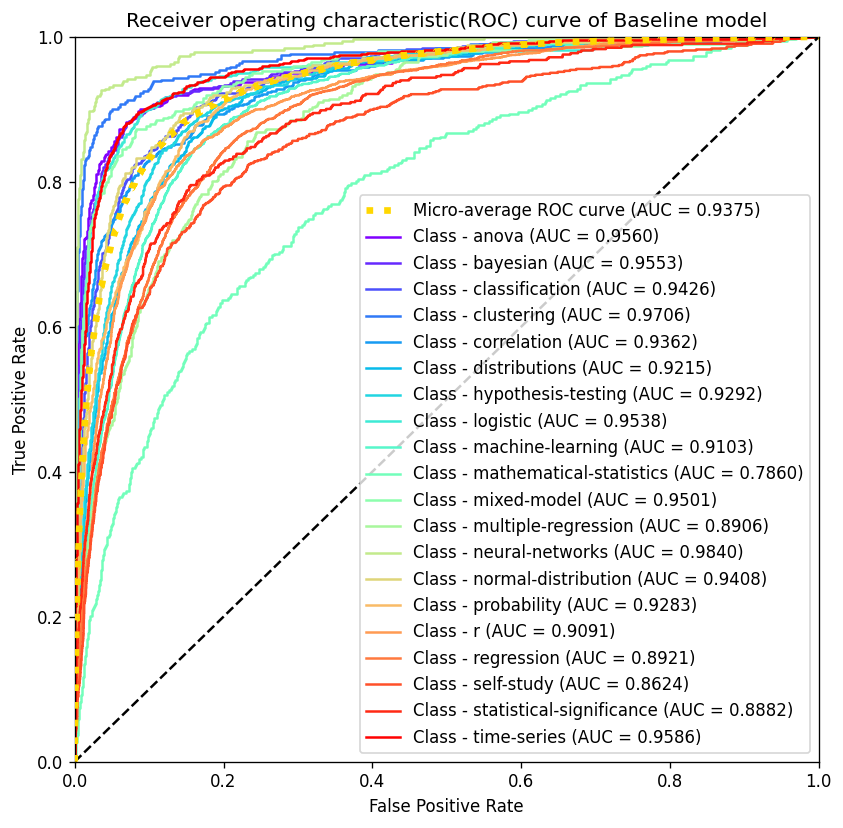

In [99]:
# ROC curve
# Source: Sklearn official example - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem
n_classes = 20
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred = base_model.predict(X_test_pad)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 8), dpi=120)
lw = 1.5 #line width

plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='gold', linestyle=':', linewidth=4, zorder=20)


colors = plt.cm.rainbow(np.linspace(0,1,n_classes))
for i, color, category in zip(range(n_classes), colors, categories):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class - {0} (AUC = {1:0.4f})'.format(category, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC) curve of Baseline model')
plt.legend(loc="lower right")
plt.show()

######**4.1.2.2. Precision-Recall curve of Baseline Model**

> Source: Sklearn official example - https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#in-multi-label-settings



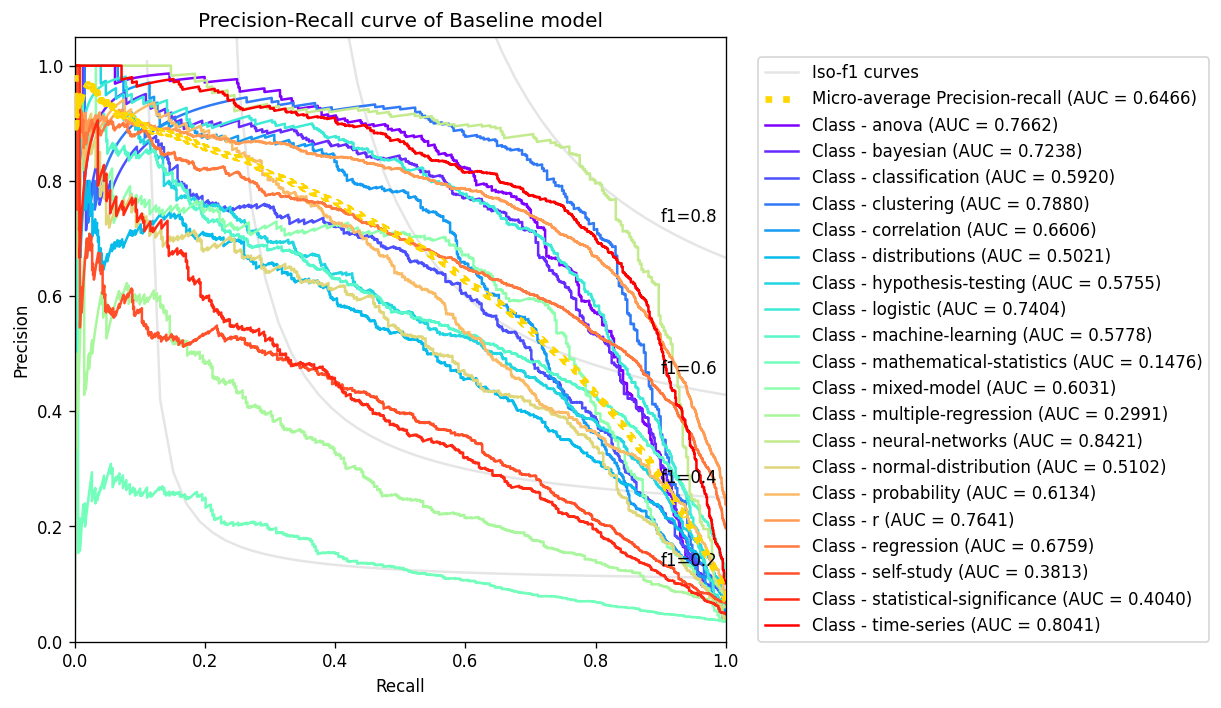

In [100]:
# PR curve 
# Source: Sklearn official example - https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#in-multi-label-settings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), 
                                                                y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred,
                                                     average="micro")

plt.figure(figsize=(7, 8), dpi=120)
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('Iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', lw=4, zorder=20)
lines.append(l)
labels.append('Micro-average Precision-recall (AUC = {0:0.4f})'
              ''.format(average_precision["micro"]))

for i, color, category in zip(range(n_classes), colors, categories):
    l, = plt.plot(recall[i], precision[i], color=color, lw=1.5)
    lines.append(l)
    labels.append('Class - {0} (AUC = {1:0.4f})'.format(category, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve of Baseline model')
plt.legend(lines, labels, loc=(1.05, 0), prop=dict(size=10))

plt.show()

####**4.2. GRU Model: Glove/Fasttest + Bidirectional GRU**

> This is the main part of the whole project. 6 network structures with 2 different embeddings (12 combinations) are compared using validation scores. All validation scores are recorded in a table. The best structure is chosen for the next part of hyperparameter tuning using hyperband from KerasTuner.



#####**4.2.1. GRU Model: Hyperparameter tuning**

> Hyperparameter tuning is broken into two parts so as to reduce the number of potential combinations in each part. 



######**4.2.1.1. Hyperparameter tuning step1: Finding the best network structure with best embedding (Glove/Fasttext-subword)**
> 6 network structures with 2 different embeddings (12 combinations) are experimented manually with keeping other hyperparameters constant:
* NO Dropout
* NO regularizer
* Optimizer: Nadam
* Learning rate: 0.001

> Possible structures:
1. Layer1: GRU with 300 hidden units 
2. Layer1: bidirectional GRU with 300 hidden units
3. Layer1: bidirectional GRU with 300 hidden units, Layer2: FC layer with 150 hidden units
4. Layer1: bidirectional GRU with 300 hidden units, Layer2: FC layer with 300 hidden units
5. Layer1: bidirectional GRU with 300 hidden units, Layer2: bidirectional GRU with 150 hidden units
6. Layer1: bidirectional GRU with 300 hidden units, Layer2: bidirectional GRU with 150 hidden units

> The number of hidden units chosen are (Word embedding vector size)/2 and (Word embedding vector size), which are 150 and 300 respectively.

> Note: FC layer = fully-connected layer





In [228]:
vec_size = 300
embedding_matrix = glove_300d_matrix

def create_model():
  # Define the structure of the model
  model = keras.Sequential([
      # Input + Embedding layer
      keras.layers.Embedding(input_dim=vocab_size, 
                             output_dim=vec_size, 
                             input_length=max_length, 
                             weights = [embedding_matrix], 
                             trainable = False, 
                             mask_zero=True),

      # GRU layer
      #keras.layers.GRU(int(vec_size)),

      # Bidirectional GRU layers
      keras.layers.Bidirectional(keras.layers.GRU(int(vec_size), return_sequences=True)),
      keras.layers.Bidirectional(keras.layers.GRU(int(vec_size/2))),

      # FC layers
      #keras.layers.Dense(int(vec_size/2), activation='relu'),

      # Output layer
      keras.layers.Dense(20, activation='sigmoid')
  ])

  # Assigning optimizer, loss function and evaluation metrices
  model.compile(optimizer=keras.optimizers.Nadam(learning_rate = 0.001),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tfa.metrics.F1Score(num_classes=20, average='micro'),
                         keras.metrics.CategoricalAccuracy(name='exact_match_ratio')])
  
  return model

In [229]:
# Model creation and summary
tf.random.set_seed(3)
rn.seed(3)
model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 300)          17616900  
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 300, 600)          1083600   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 300)               676800    
_________________________________________________________________
dense_11 (Dense)             (None, 20)                6020      
Total params: 19,383,320
Trainable params: 1,766,420
Non-trainable params: 17,616,900
_________________________________________________________________


In [230]:
# Parameters
epochs = 3
batch_size = 32
class_weight = class_weights

# Training the model
model.fit(X_train_train, 
          y_train_train, 
          epochs = epochs, 
          batch_size = batch_size, 
          class_weight = class_weight, 
          validation_data=(X_train_val, y_train_val))

Epoch 1/3
1131/1131 [==============================] - 106s 82ms/step - loss: 0.6130 - f1_score: 0.4728 - exact_match_ratio: 0.4531 - val_loss: 0.1277 - val_f1_score: 0.5736 - val_exact_match_ratio: 0.5630
Epoch 2/3
1131/1131 [==============================] - 90s 80ms/step - loss: 0.4171 - f1_score: 0.6074 - exact_match_ratio: 0.6024 - val_loss: 0.1204 - val_f1_score: 0.5951 - val_exact_match_ratio: 0.5938
Epoch 3/3
1131/1131 [==============================] - 90s 80ms/step - loss: 0.3692 - f1_score: 0.6310 - exact_match_ratio: 0.6257 - val_loss: 0.1189 - val_f1_score: 0.6073 - val_exact_match_ratio: 0.5981


In [231]:
# Calculate ROC-AUC
y_val_pred = model.predict(X_train_val)
fpr, tpr, _ = roc_curve(y_train_val.ravel(), y_val_pred.ravel())
micro_roc_auc = auc(fpr, tpr)

In [232]:
# Calculate Area under Precision-recall curve (AP)
micro_ap = average_precision_score(y_train_val, y_val_pred, average="micro")

In [233]:
# ROC-AUC & AP
micro_roc_auc, micro_ap

(0.9553237470072405, 0.7154776470393002)

**Model Comparison**  

> Area under the curve of receiver operating characteristic(ROC AUC), Area under precision-recall curve (AP), micro f1-score and exact match ratio (EMR) are used as indicators to compare different models' performances.


> According to the table below, bidirectional GRU with 2 hidden layers of 300 & 150 neurons using Glove embedding performs the best in all indictors. However, the differences between bidirectional GRU are not significant.





**Table of comparing 5 network structures with Glove/Fasttext word embedding**  

| #Layer | Directionality | Layer1(hidden size) | Layer2(hidden size) | Word Embedding | Val (ROC AUC) | Val (AP) | Micro-F1 | EMR |
| :- | :- | :- | :- | :- | :- | :- | :- | :- |
| 1 | Single | GRU(300) | N/A | fasttext | 0.9480 | 0.6908 | 0.5896 | 0.5842 |
| 1 | Single | GRU(300) | N/A | glove | 0.9448 | 0.6840 | 0.5903 | 0.5742 |
| 1 | Bidirectional | GRU(300) | N/A | fasttext | 0.9493 | 0.7006 | 0.5896 | 0.5842 |
| 1 | Bidirectional | GRU(300) | N/A | glove | 0.9543 | 0.7140 | 0.5903 | 0.5742 |
| 2 | Bidirectional | GRU(300) | FC(150) | fasttext | 0.9506 | 0.7028 | 0.5960 | 0.5916 |
| 2 | Bidirectional | GRU(300) | FC(150) | glove | 0.9532 | 0.7092 | 0.6051 | 0.5960 |
| 2 | Bidirectional | GRU(300) | FC(300) | fasttext | 0.9498 | 0.7010 | 0.5943 | 0.5872 |
| 2 | Bidirectional | GRU(300) | FC(300) | glove | 0.9421 | 0.6593 | 0.6048 | 0.5953 |
| 2 | Bidirectional | GRU(300) | GRU(150) | fasttext | 0.9510 | 0.7000 | 0.6015 | 0.5880 |
| **2** | **Bidirectional** | **GRU(300)** | **GRU(150)** | **glove** | **0.9553** | **0.7154** | **0.6073** | **0.5981** |
| 2 | Bidirectional | GRU(300) | GRU(300) | fasttext | 0.9496 | 0.6763 | 0.6047 | 0.5994 |
| 2 | Bidirectional | GRU(300) | GRU(300) | glove | 0.9479 | 0.6929 | 0.6070 | 0.5937

######**4.2.1.2. Hyperparameter tuning step2: Finding the best dropout/regularizer/optimizer**  
> Hyperband in KerasTuner is used for step 2 hyperparameter tuning. As there are too many potential combinations, it is highly-computationally expensive and time-consuming to try every single combination of hyperparameters. The following hyperparameters are chosen in the following experimental setup.

> Options of hyperparameters (potential combinations = 500):
* Dropout rate: 0(No dropout), 0.1, 0.2, 0.3, 0.4, 0.5  
* L1 Regularizer: Penalties of [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
* L2 Regularizer: Penalties of [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
* Optimizer: Adam, Nadam, Adamax, Adagrad




In [101]:
vec_size=300
def create_model(hp):
  hp_dropout_rates = hp.Choice('Dropout_rate', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  hp_l1_reg = hp.Choice('L1_penalty', values=[1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
  hp_l2_reg = hp.Choice('L2_penalty', values=[1e-4, 1e-5, 1e-6, 1e-7, 1e-8])

  model = keras.Sequential([
      keras.layers.Embedding(input_dim=vocab_size, 
                             output_dim=vec_size, 
                             input_length=max_length, 
                             weights = [glove_300d_matrix], 
                             trainable = False, 
                             mask_zero=True),
      keras.layers.Bidirectional(keras.layers.GRU(units=300, return_sequences=True)),
      keras.layers.Bidirectional(keras.layers.GRU(units=150, kernel_regularizer=keras.regularizers.l1_l2(l1=hp_l1_reg, l2=hp_l2_reg))),                                            
      keras.layers.Dropout(rate=hp_dropout_rates),
      keras.layers.Dense(20, activation='sigmoid')
  ])

  hp_optimizer = hp.Choice('Optimizer', values=['Adam', 'Nadam', 'Adamax', 'Adagrad'])

  model.compile(optimizer=hp_optimizer,
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tfa.metrics.F1Score(num_classes=20, average='micro', name='micro_f1'),
                         keras.metrics.BinaryAccuracy(),
                         keras.metrics.CategoricalAccuracy(name='exact_match_ratio')])
  
  return model



> In the Hyperband, maximising validation micro f1-score is chosen as the objective for selecting the best hyperparemeters. Also, early stop is applied to reduce the amount of time if the model is overfitting the training data. If there is no improvement of objective within 2 epochs after the best epoch, that combination of hyperparameters will be skipped.




In [102]:
tuner = kt.Hyperband(create_model,
                     objective=kt.Objective("val_micro_f1", direction="max"),
                     max_epochs=10,
                     factor=3)
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_micro_f1", patience=2)

In [103]:
tuner.search(x=X_train_train, 
             y=y_train_train, 
             validation_data=(X_train_val, y_train_val), 
             callbacks=[stop_early],
             class_weight=class_weights)

Trial 30 Complete [00h 04m 45s]
val_micro_f1: 0.6042057871818542

Best val_micro_f1 So Far: 0.6106197834014893
Total elapsed time: 01h 59m 26s
INFO:tensorflow:Oracle triggered exit



> It is found that hyperband can further improve the model's micro f1-score to 0.6106 with the following hyperparameters.



In [104]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
for key in best_hps.values:
  print('best', key, ': ', best_hps.values[key])

best Dropout_rate :  0.2
best L1_penalty :  1e-07
best L2_penalty :  1e-07
best Optimizer :  Adam
best tuner/epochs :  4
best tuner/initial_epoch :  0
best tuner/bracket :  1
best tuner/round :  0


#####**4.2.2. Best GRU model**
> Best Network Structure:
* Embedding: Glove - 300D  
* Layer1: Bidirectional GRU - 300 hidden units  
* Layer2: Bidirectional GRU - 150 hidden units  
* Layer3: Dropout layer - rate: 0.2
* Output layer: Fully-connected (activation function: sigmoid) - 20 units


> Best Hyperparameters:
* L1 regularizer: 1e-7 penalty  
* L2 regularizer: 1e-7 penalty  
* Optimizer: Adam  
* Learning rate: 0.001(default)  


In [197]:
def create_best_model():
  # Define the structure of the model
  model = keras.Sequential([
      # Input + Embedding layer
      keras.layers.Embedding(input_dim=vocab_size, 
                             output_dim=vec_size, 
                             input_length=max_length, 
                             weights = [glove_300d_matrix], 
                             trainable = False, 
                             mask_zero=True),

      # Bidirectional GRU layers
      keras.layers.Bidirectional(keras.layers.GRU(int(vec_size), return_sequences=True)),
      keras.layers.Bidirectional(keras.layers.GRU(int(vec_size/2), kernel_regularizer=keras.regularizers.l1_l2(l1=1e-7, l2=1e-7))),

      # Dropout layer
      keras.layers.Dropout(rate=0.2),

      # Output layer
      keras.layers.Dense(20, activation='sigmoid')
  ])

  # Assigning optimizer, loss function and evaluation metrices
  model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tfa.metrics.F1Score(num_classes=20, average='micro', name='micro_f1'),
                         tfa.metrics.F1Score(num_classes=20, average='macro', name='macro_f1'),
                         tfa.metrics.HammingLoss(mode='multilabel'),
                         keras.metrics.CategoricalAccuracy(name='exact_match_ratio')])
  
  return model

# Model creation and summary
tf.random.set_seed(3)
rn.seed(3)
best_model = create_best_model()
best_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 300)          17616900  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 300, 600)          1083600   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 300)               676800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                6020      
Total params: 19,383,320
Trainable params: 1,766,420
Non-trainable params: 17,616,900
_________________________________________________________________


In [106]:
# Training the model
history = best_model.fit(X_train_train, 
                         y_train_train, 
                         epochs = 10, 
                         batch_size = 32, 
                         class_weight = class_weights, 
                         validation_data=(X_train_val, y_train_val))

Epoch 1/10
1131/1131 [==============================] - 102s 81ms/step - loss: 0.6523 - micro_f1: 0.4413 - macro_f1: 0.4159 - hamming_loss: 0.0675 - exact_match_ratio: 0.4209 - val_loss: 0.1281 - val_micro_f1: 0.5868 - val_macro_f1: 0.5829 - val_hamming_loss: 0.0500 - val_exact_match_ratio: 0.5846
Epoch 2/10
1131/1131 [==============================] - 88s 78ms/step - loss: 0.4417 - micro_f1: 0.5996 - macro_f1: 0.5962 - hamming_loss: 0.0485 - exact_match_ratio: 0.5944 - val_loss: 0.1244 - val_micro_f1: 0.5960 - val_macro_f1: 0.5899 - val_hamming_loss: 0.0489 - val_exact_match_ratio: 0.5937
Epoch 3/10
1131/1131 [==============================] - 89s 78ms/step - loss: 0.3945 - micro_f1: 0.6234 - macro_f1: 0.6208 - hamming_loss: 0.0456 - exact_match_ratio: 0.6198 - val_loss: 0.1241 - val_micro_f1: 0.6078 - val_macro_f1: 0.5963 - val_hamming_loss: 0.0474 - val_exact_match_ratio: 0.5990
Epoch 4/10
1131/1131 [==============================] - 88s 78ms/step - loss: 0.3486 - micro_f1: 0.6483 -

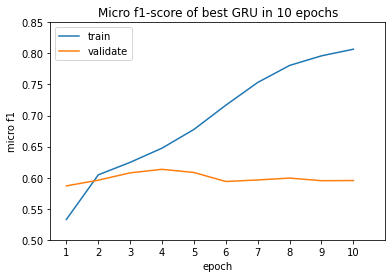

In [133]:
plt.figure()
plt.plot(history.history['micro_f1'])
plt.plot(history.history['val_micro_f1'])
plt.title('Micro f1-score of best GRU in 10 epochs')
plt.xlim([-0.5, 10])
plt.ylim([0.5, 0.85])
plt.ylabel('micro f1')
plt.xlabel('epoch')
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

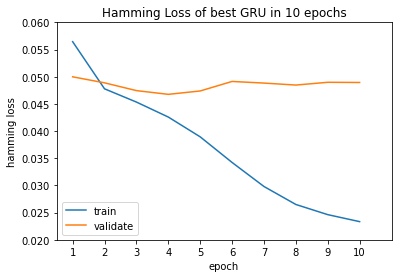

In [118]:
plt.figure()
plt.plot(history.history['hamming_loss'])
plt.plot(history.history['val_hamming_loss'])
plt.title('Hamming Loss of best GRU in 10 epochs')
plt.xlim([-0.5, 10])
plt.ylim([0.02, 0.06])
plt.ylabel('hamming loss')
plt.xlabel('epoch')
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(['train', 'validate'], loc='lower left')
plt.show()

#####**4.2.3. Evaluation of the best GRU model with testing data**

> The best model is retrained using all the training data and evaluated with the testing data. It is found that validation micro f1-score and exact match ratio stops improving after the 4th epoch. Overfitting occurs after the 1st epoch.

> Receiver operating characteristic(ROC) curve and Precision-recall curve are also plotted to review the performances in predicting different classes.





In [120]:
best_epoch_model = create_best_model()
best_epoch_model.fit(X_train_pad, 
                     y_train, 
                     epochs = 4, 
                     batch_size = 32, 
                     class_weight = class_weights)

Epoch 1/4
1413/1413 [==============================] - 113s 71ms/step - loss: 0.6334 - micro_f1: 0.4614 - macro_f1: 0.4420 - hamming_loss: 0.0651 - exact_match_ratio: 0.4463
Epoch 2/4
1413/1413 [==============================] - 101s 72ms/step - loss: 0.4325 - micro_f1: 0.6048 - macro_f1: 0.5994 - hamming_loss: 0.0478 - exact_match_ratio: 0.6000
Epoch 3/4
1413/1413 [==============================] - 101s 71ms/step - loss: 0.3880 - micro_f1: 0.6261 - macro_f1: 0.6248 - hamming_loss: 0.0451 - exact_match_ratio: 0.6222
Epoch 4/4
1413/1413 [==============================] - 101s 72ms/step - loss: 0.3443 - micro_f1: 0.6553 - macro_f1: 0.6577 - hamming_loss: 0.0416 - exact_match_ratio: 0.6518


In [234]:
# Evaluate the model with testing(unseen) data
results = best_epoch_model.evaluate(X_test_pad, y_test, verbose=0)
print('Micro f1-score: {0}'.format(results[1]))
print('Macro f1-score: {0}'.format(results[2]))
print('Hamming loss: {0}'.format(results[3]))
print('Exact match ratio: {0}'.format(results[4]))

Micro f1-score: 0.6036224961280823
Macro f1-score: 0.5995775461196899
Hamming loss: 0.04810074344277382
Exact match ratio: 0.600713312625885


######**4.2.3.1. Confusion matrices of the best GRU Model**

> Source: one of our groupmates - Prabha




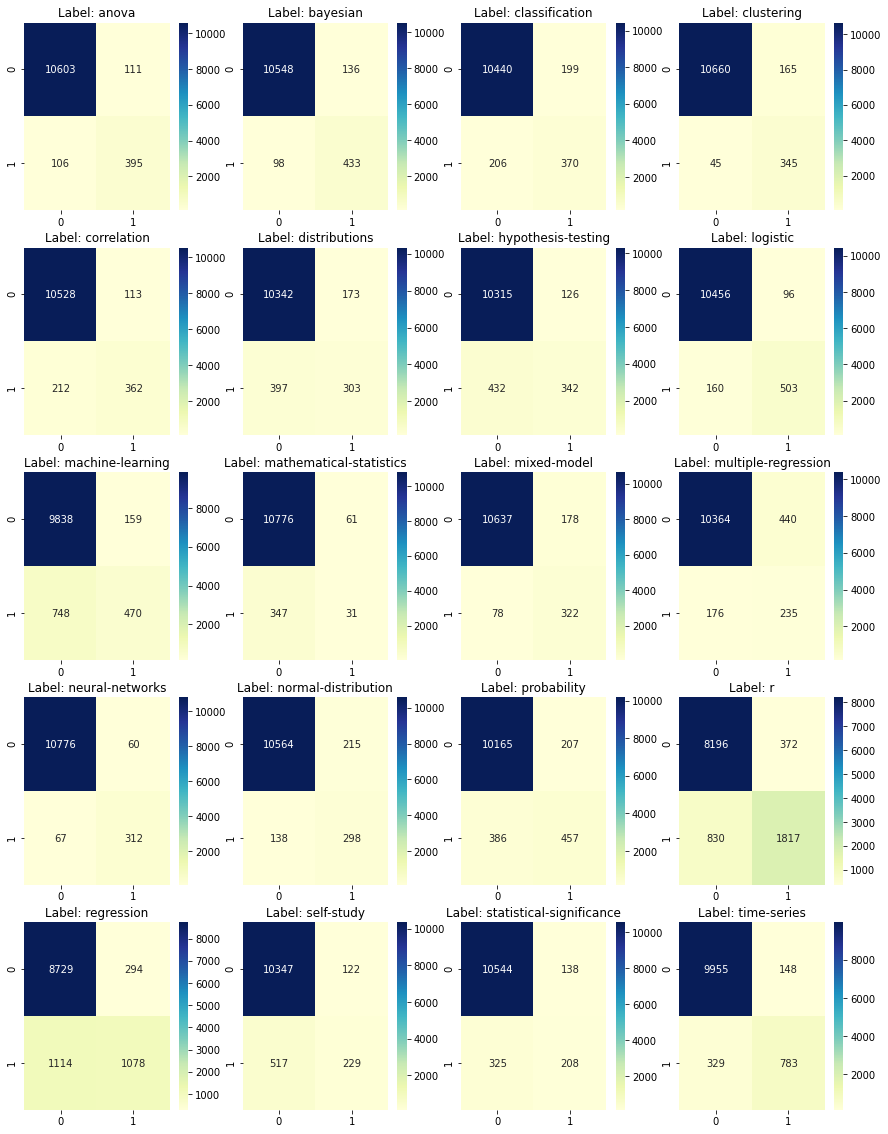

In [247]:
# Confusion matrices
y_pred = best_epoch_model.predict(X_test_pad)
confusion_matrix = multilabel_confusion_matrix(y_test, np.array([[round(num) for num in row] for row in y_pred]))

fig = plt.figure(figsize=(15, 20))

cols = 4
rows = math.ceil(len(categories)/cols)
for i, col in enumerate(categories):
  ax = fig.add_subplot(rows, cols, i+1)
  sns.heatmap(confusion_matrix[i], annot=True, fmt="d", cmap="YlGnBu")
  ax.set(title='Label: {0}'.format(col))

plt.show()

######**4.2.3.2. Receiver operating characteristic(ROC) curve of best GRU Model**

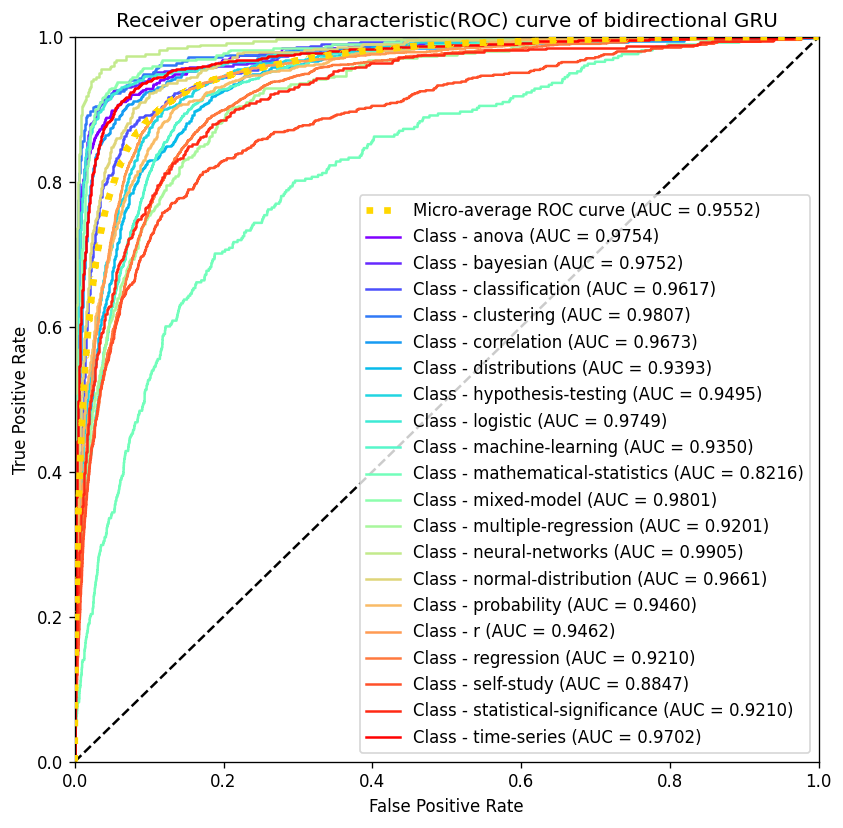

In [213]:
# ROC curve
# Source: Sklearn official example - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem
n_classes = 20
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred = best_epoch_model.predict(X_test_pad)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 8), dpi=120)
lw = 1.5 #line width

plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='gold', linestyle=':', linewidth=4, zorder=20)


colors = plt.cm.rainbow(np.linspace(0,1,n_classes))
for i, color, category in zip(range(n_classes), colors, categories):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class - {0} (AUC = {1:0.4f})'.format(category, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC) curve of bidirectional GRU')
plt.legend(loc='lower right')
plt.show()

######**4.2.3.3. Precision-Recall curve of best GRU Model**

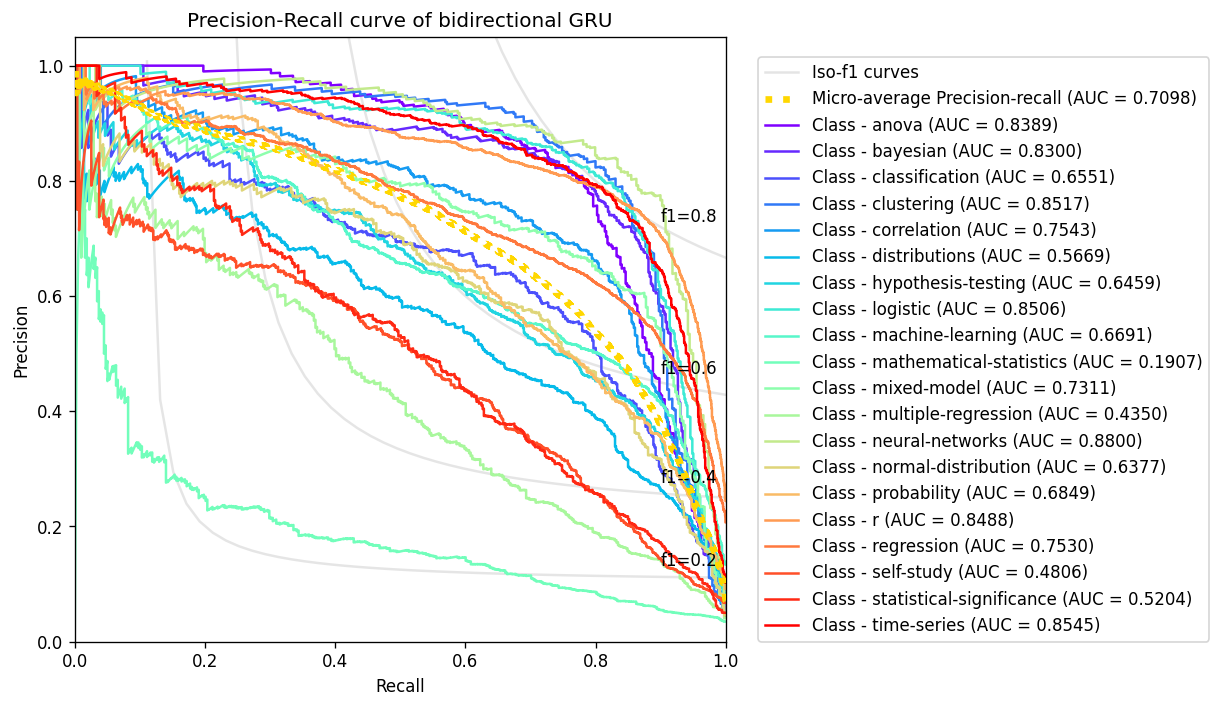

In [212]:
# PR curve 
# Source: Sklearn official example - https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#in-multi-label-settings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), 
                                                                y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred,
                                                     average="micro")

plt.figure(figsize=(7, 8), dpi=120)
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('Iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', lw=4, zorder=20)
lines.append(l)
labels.append('Micro-average Precision-recall (AUC = {0:0.4f})'
              ''.format(average_precision["micro"]))

for i, color, category in zip(range(n_classes), colors, categories):
    l, = plt.plot(recall[i], precision[i], color=color, lw=1.5)
    lines.append(l)
    labels.append('Class - {0} (AUC = {1:0.4f})'.format(category, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve of bidirectional GRU')
plt.legend(lines, labels, loc=(1.05, 0))

plt.show()

**Evaluation Summary**  

> Confusion matrices are generated. ROC and Precision-recall curve are plotted with individual scores and micro-average of all labels. 20 confusion matrices show the true-positive, true negative, false-positive and false-negative of all 20 labels. From the precision-recall curve, it could be observed that performances of different label can vary a lot. The worst AP is merely 0.1907, while the best AP is 0.88.


> It is worth-mentioning that the least abundant label "mathematical-statistics" performs significantly worse than the rest of all labels with only AP of 0.1907 comparing with the micro-average AP of 0.7098. However, the second least abundant label "neural-networks" has the best AP(0.88) among all labels. Therefore, it can be deduced that imbalanced label is not the only reason for the bad scores of "mathematical-statistics".





####**4.3. Transfer Learning: ALBERT**

> Source: https://tfhub.dev/tensorflow/albert_en_base/2

> ALBERT is trained using the training data and validated directly with the testing data as no hyperparameter tuning is needed in this section. All scores are recorded in section 5 for final comparison.



#####**4.3.1. Building ALBERT**

In [125]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessor = hub.KerasLayer("http://tfhub.dev/tensorflow/albert_en_preprocess/3")
  encoder_inputs = preprocessor(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/2", trainable=True)
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(20, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
!pip install tf-models-official

In [127]:
from official.nlp import optimization
epochs = 10
steps_per_epoch = len(X)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [130]:
def create_transfer_model():
  model = build_classifier_model()

  model.compile(optimizer=optimizer,
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tfa.metrics.F1Score(num_classes=20, average='micro', name='micro_f1'),
                         tfa.metrics.F1Score(num_classes=20, average='macro', name='macro_f1'),
                         tfa.metrics.HammingLoss(mode='multilabel'),
                         keras.metrics.CategoricalAccuracy(name='exact_match_ratio')])
  
  return model

In [131]:
transfer_model = create_transfer_model()
transfer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      {'encoder_outputs':  11683584    keras_layer_2[0][0]              
                                                                 keras_layer_2[0][1]              
                                                                 keras_layer_2[0][2]              
____________________________________________________________________________________________

In [132]:
model.fit(X_train, 
          y_train,
          validation_data=(X_test, y_test),
          epochs = 10,
          batch_size = 32,
          class_weight = class_weights)

Epoch 1/10
1413/1413 [==============================] - 932s 653ms/step - loss: 1.9222 - micro_f1: 0.0700 - macro_f1: 0.0326 - hamming_loss: 0.1124 - exact_match_ratio: 0.0664 - val_loss: 0.2368 - val_micro_f1: 0.2567 - val_macro_f1: 0.0760 - val_hamming_loss: 0.0902 - val_exact_match_ratio: 0.2040
Epoch 2/10
1413/1413 [==============================] - 921s 652ms/step - loss: 0.8534 - micro_f1: 0.2965 - macro_f1: 0.1593 - hamming_loss: 0.0851 - exact_match_ratio: 0.2397 - val_loss: 0.1846 - val_micro_f1: 0.4942 - val_macro_f1: 0.4188 - val_hamming_loss: 0.0614 - val_exact_match_ratio: 0.4524
Epoch 3/10
1413/1413 [==============================] - 922s 652ms/step - loss: 0.6341 - micro_f1: 0.5082 - macro_f1: 0.4600 - hamming_loss: 0.0594 - exact_match_ratio: 0.4811 - val_loss: 0.1489 - val_micro_f1: 0.5595 - val_macro_f1: 0.5376 - val_hamming_loss: 0.0535 - val_exact_match_ratio: 0.5434
Epoch 4/10
1413/1413 [==============================] - 921s 652ms/step - loss: 0.5226 - micro_f1: 0

#####**4.3.2. Evaluation of ALBERT**

In [138]:
# Calculate ROC-AUC
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
micro_roc_auc = auc(fpr, tpr)

In [139]:
# Calculate Area under Precision-recall curve (AP)
micro_ap = average_precision_score(y_test, y_pred, average="micro")

In [140]:
micro_roc_auc, micro_ap

(0.9494375157086885, 0.710100662282455)

###**5. Final Model Comparison**

> From the table below, it is observed that both bidirectional GRU and ALBERT are able to beat the baseline model. Bidirectional GRU performs better than ALBERT in all scores except the area under precision-recall curve (AP) with a slight difference of 0.0003.





| Model | Test (ROC AUC) | Test (AP) | Test (Micro-F1) | Test (Hamming loss) | Test (EMR) |
| :- | :- | :- | :- | :- | :- |
| Baseline model | 0.9375 | 0.6466 | 0.5572 | 0.0536 | 0.5375 |
| Bidirectional GRU | 0.9552 | 0.7098 | 0.6036 | 0.0481 | 0.6007 |
| ALBERT | 0.9494 | 0.7101 | 0.6002 | 0.0485 | 0.5930 | 

###**6. Project Summary and Evaluation**

> In summary, the result is satisfactory in bidirectional GRU. It achieves a micro-average ROC-AUC of 0.9552, and 75% of the labels have a f1-score of over 0.6 as shown in the precision-recall curve with 3 labels over 0.8.


> Text preprocessing, due to the nature of our input text, a lot of redundant words still exist in the input texts after removing the stopwords, for example the random variables x y z. In the initial training, the result is unsatisfactory. Retraining has to be done after removing meaningless word in the input texts. Also, it is not ideal that around 40% of the vocabruaries (22000 out of 58000) are not mapped with pre-trained word embeddings.


> Choice of models: A lot of variations in GRU model has been shown in the experiment. Random seeds in modules have been set to make sure the comparison between models are fair. The model variations are not randomly chosen. Models were retrained for numerous times with different position of dropout layer, a deeper neural network with 3~4 hidden layers. However, these variations are not shown in the report as it is not carried out in an organised way.

> Comparing with the single-directional GRU model with 300 hidden units (the simplest one in 12 variations), the improvement after hyperparameters tuning is not very significant. It is believed that the input text can be furthered preprocessed to improve the performance of the model. Some of the techniques are not used throughout the experiment, such as TFIDF and n-grams, as they are experimented by other groupmates.





